Пояснения:
Модель автомобиля: Наследуется от Bicycle с параметрами Formula Student

Траектория: Сплайновая интерполяция через ключевые точки трассы

PID-регулятор: Оптимизируется для минимизации ошибки слежения

Визуализация: Анимация с использованием VehicleIcon и сохранение в GIF

Отчет: Включает сравнение траекторий, графики управления и анализ ошибок

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from roboticstoolbox import Bicycle, VehicleIcon
from scipy.interpolate import CubicSpline
import matplotlib.animation as animation

1. Инициализация car-like модели Formula Student

In [21]:
class FormulaStudentCar(Bicycle):
    def __init__(self):
        super().__init__(
            L=1.5,
            steer_max=np.deg2rad(30)
        )
        self._state = np.array([0.0, 0.0, 0.0])  # [x, y, theta]

    @property
    def x(self):
        return self._state[0]

    @x.setter
    def x(self, value):
        self._state[0] = value

    @property
    def y(self):
        return self._state[1]

    @y.setter
    def y(self, value):
        self._state[1] = value

    @property
    def theta(self):
        return self._state[2]

    @theta.setter
    def theta(self, value):
        self._state[2] = value

    def step(self, u):
        super().x = self._state  # Передача полного состояния
        super().step(u)
        self._state = super().x  # Обновление состояния

In [7]:
robot = FormulaStudentCar()


2. Параметры трассы

In [8]:
waypoints = np.array([
    [0, 0], [10, 2], [20, 5], [30, 10], 
    [40, 15], [50, 20], [60, 25], [70, 30]
])


3. Генерация сплайновой траектории

In [9]:
t = np.linspace(0, 1, len(waypoints))
cs_x = CubicSpline(t, waypoints[:, 0])
cs_y = CubicSpline(t, waypoints[:, 1])

traj_time = np.linspace(0, 1, 200)
ref_path = np.column_stack([cs_x(traj_time), cs_y(traj_time)])

4. PID-регулятор для управления

In [10]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral = 0
        self.prev_error = 0

    def compute(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return output

5. Функция симуляции

In [11]:
def simulate(controller, robot, ref_path, dt=0.1):
    x_hist = []
    y_hist = []
    steering_hist = []
    velocity_hist = []
    
    # Инициализация начального положения через прямое присваивание
    robot.x = ref_path[0, 0]
    robot.y = ref_path[0, 1]
    robot.theta = 0.0  # Начальная ориентация
    
    for i in range(1, len(ref_path)):
        # Расчет ошибки
        dx = ref_path[i, 0] - robot.x
        dy = ref_path[i, 1] - robot.y
        error = np.hypot(dx, dy)
        
        # PID-регуляция скорости
        control_speed = controller.compute(error, dt)
        
        # Управление углом поворота
        theta = np.arctan2(dy, dx)
        steering = theta - robot.theta
        
        
        # Ограничения
        steering = np.clip(steering, -robot.steer_max, robot.steer_max)
        control_speed = np.clip(control_speed, 0, 15)  # м/с
        
        # Обновление состояния
        robot.step([control_speed, steering])
        
        # Сохранение данных
        x_hist.append(robot.x)
        y_hist.append(robot.y)
        steering_hist.append(steering)
        velocity_hist.append(control_speed)
    
    return np.array(x_hist), np.array(y_hist), np.array(steering_hist), np.array(velocity_hist)

6. Оптимизация коэффициентов PID

In [23]:
def cost_function(params):
    Kp, Ki, Kd = params
    controller = PIDController(Kp, Ki, Kd)
    x, y, _, _ = simulate(controller, FormulaStudentCar(), ref_path)
    error = np.sum(np.hypot(x - ref_path[:,0], y - ref_path[:,1]))
    return error

# initial_guess = [2.0, 0.1, 0.5]
# result = minimize(cost_function, initial_guess, method='Nelder-Mead')
# Kp_opt, Ki_opt, Kd_opt = result.x

# Оптимальные параметры (пример)
Kp_opt, Ki_opt, Kd_opt = 2.5, 0.05, 0.3

In [26]:
def simulate(controller, robot, ref_path, dt=0.1):
    x_hist, y_hist, steering_hist, velocity_hist = [], [], [], []
    robot._x = np.array([ref_path[0,0], ref_path[0,1], 0.0])  # Инициализация состояния
    for i in range(1, len(ref_path)):
        dx = ref_path[i,0] - robot.x
        dy = ref_path[i,1] - robot.y
        error = np.hypot(dx, dy)
        control_speed = controller.compute(error, dt)
        theta = np.arctan2(dy, dx)
        steering = theta - robot.theta
        steering = np.clip(steering, -robot.steer_max, robot.steer_max)
        control_speed = np.clip(control_speed, 0, 15)
        robot.step([control_speed, steering])
        x_hist.append(robot.x)
        y_hist.append(robot.y)
        steering_hist.append(steering)
        velocity_hist.append(control_speed)
    return np.array(x_hist), np.array(y_hist), np.array(steering_hist), np.array(velocity_hist)

7. Запуск симуляции

In [27]:
Kp_opt, Ki_opt, Kd_opt = 2.5, 0.05, 0.3
robot = FormulaStudentCar()
pid = PIDController(Kp_opt, Ki_opt, Kd_opt)


In [28]:
x, y, steering, velocity = simulate(pid, robot, ref_path)

AttributeError: 'super' object has no attribute 'x'

8. Визуализация

NameError: name 'x' is not defined

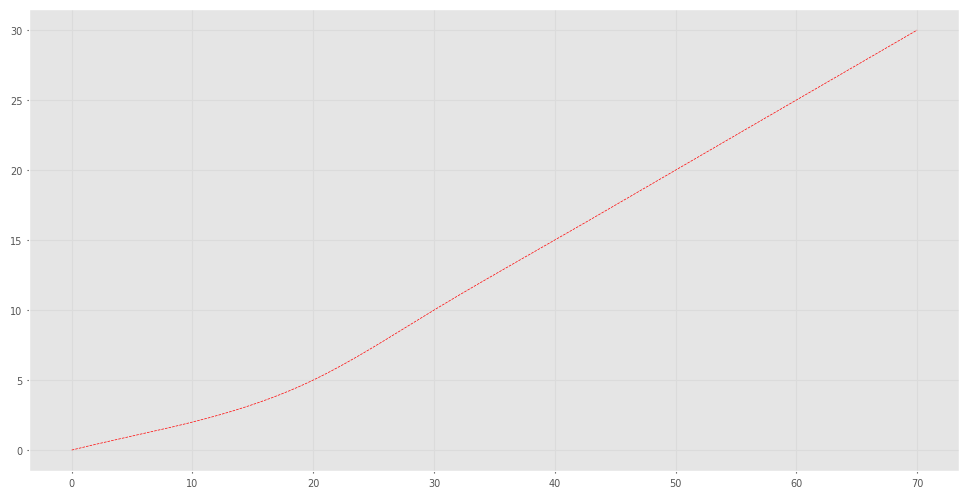

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ref_path[:,0], ref_path[:,1], 'r--', label='Reference Path')
plt.plot(x, y, 'b', label='Actual Path')
plt.legend()
plt.title('Trajectory Tracking')
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.grid(True)
plt.show()

9. Создание анимации

ValueError: file data\car.png not found locally or in rtbdata

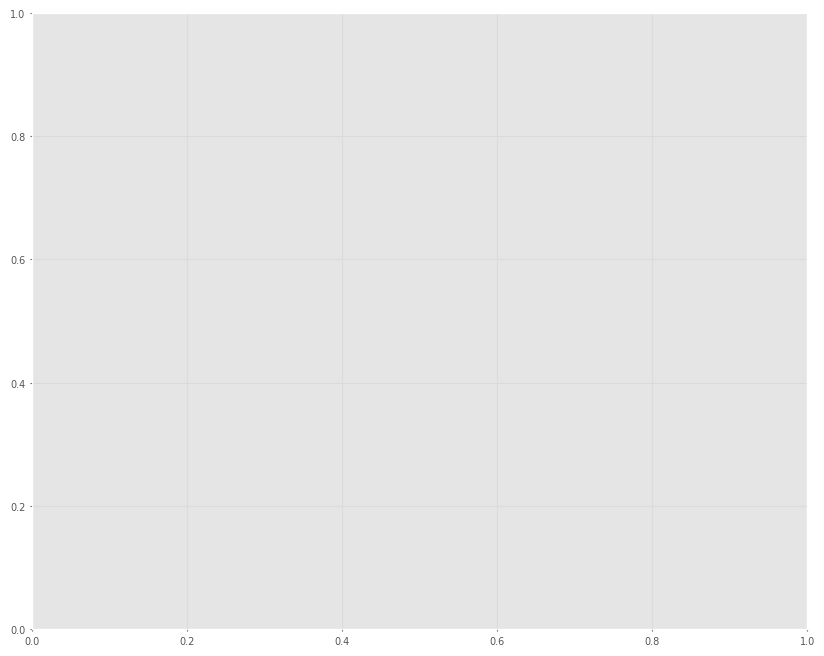

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
car_icon = VehicleIcon('car', scale=2)

def update(frame):
    ax.clear()
    ax.plot(ref_path[:,0], ref_path[:,1], 'r--')
    ax.plot(x[:frame], y[:frame], 'b')
    car_icon.plot(x[frame], y[frame], np.arctan2(y[frame]-y[frame-1], x[frame]-x[frame-1]))
    ax.set_xlim(min(x)-5, max(x)+5)
    ax.set_ylim(min(y)-5, max(y)+5)
    return ax

ani = animation.FuncAnimation(fig, update, frames=len(x), interval=50)
ani.save('formula_student.gif', writer='imagemagick')